## Demonstrating the Workflow of the Online_IO Class: Online Gradient Descent

### Stephanie Allen, *AMSC PhD, UMD-College Park* 

We will demonstrate through the Markdown and code blocks below the workflow of the `Online_IO` class for the `BMPS_online_GD` online inverse optimization option.  We will be replicating an experiment from Bärmann, Martin, Pokutta, & Schneider's 2018 paper, "An Online-Learning Approach to Inverse Optimization" [1].  The algorithm is also from [1]; our contribution is the implementation, and the construction of the `Online_IO` class.

We provide more detailed explanation regarding the set up of `Online_IO` in the DCZ Jupyter notebook.  In this notebook, we will take users through the experiment for [1].

Environment set up comes first!  We then load in the experiment data.

In [1]:
import sys
sys.path.insert(0,"C:\\Users\\StephanieAllen\\Documents\\1_AMSC663\\Repository_for_Code")

import math
import copy
import time
import pdb #for debugging
import numpy as np                     
import pyomo.environ as pyo
from pyomo.opt import SolverFactory 
from pyomo.opt import SolverStatus, TerminationCondition
import matplotlib.pyplot as plt #http://www.scipy-lectures.org/intro/matplotlib/matplotlib.html#simple-plot
import pickle

from online_IO_files.online_IO_source.online_IO import Online_IO #importing the GIO class for testing
### Uncomment the line below to generate new data ###
#from online_IO_files.experiments.experiment_BMPS_consumer_behavior_gen_data import num_samples
num_samples = 500

In [3]:
### Loading Data ###
loading_data_info = open("BMPS_p_t.pickle","rb")
p_t_samples = pickle.load(loading_data_info) 
loading_data_info.close()

#pdb.set_trace()

loading_data_info2 = open("BMPS_x_t.pickle","rb")
x_t_samples = pickle.load(loading_data_info2)
loading_data_info2.close()

loading_data_info3 = open("BMPS_RHS_t.pickle","rb")
RHS_t_samples = pickle.load(loading_data_info3)
loading_data_info3.close()

loading_data_info4 = open("BMPS_true_utility_vec.pickle","rb")
true_u_vec = pickle.load(loading_data_info4) 
true_u_vec = -1*true_u_vec #since we are minimizing the negative 
#so the guesses that come back will be negative utility values
loading_data_info4.close()


print("Demonstrating that random values were generated for p_t")
print("p_40",p_t_samples[40])
print("p_80",p_t_samples[80])
print("p_120",p_t_samples[120])
print("p_200",p_t_samples[200])


Demonstrating that random values were generated for p_t
p_40 {(1, 1): 98.01760195817285, (1, 2): 102.02980454267305, (1, 3): 105.02750080990604, (1, 4): 108.03480796227637, (1, 5): 96.03426802490911, (1, 6): 93.01652208343832, (1, 7): 110.00745113566826, (1, 8): 93.02832871386919, (1, 9): 109.0197977034664, (1, 10): 90.01688204168316, (1, 11): 96.02062560742954, (1, 12): 96.00673121917858, (1, 13): 90.03362010006839, (1, 14): 90.02836470969368, (1, 15): 108.00925092689248, (1, 16): 101.03275620028077, (1, 17): 109.02620496022462, (1, 18): 99.03538389546813, (1, 19): 95.02159749469061, (1, 20): 100.02811273892229, (1, 21): 105.02771678485296, (1, 22): 98.01007883085562, (1, 23): 109.00010798747346, (1, 24): 92.01842986213599, (1, 25): 109.00673121917858, (1, 26): 101.00381555739534, (1, 27): 106.00050394154277, (1, 28): 96.02724883913466, (1, 29): 108.01943774522155, (1, 30): 91.02379323998416, (1, 31): 92.00579532774198, (1, 32): 97.03358410424391, (1, 33): 102.01821388718909, (1, 34):

We set up the optimization model below from the experiment defined in [1].  Remember, we just have to define the index sets and the parameters!

In [4]:
#####    Set up FORWARD Model    #######
#a. Sets and Vars
cb_model_BMPS = pyo.ConcreteModel()
cb_model_BMPS.varindex = pyo.RangeSet(1,50)
cb_model_BMPS.x = pyo.Var(cb_model_BMPS.varindex,domain=pyo.NonNegativeReals)
cb_model_BMPS.numvars = pyo.Param(initialize=50)
cb_model_BMPS.eqindex = pyo.RangeSet(1,1)

#b. Parameters
cb_model_BMPS.p_t = pyo.Param(cb_model_BMPS.eqindex,\
                        cb_model_BMPS.varindex,initialize=0) #do not need to define mutability here 
                                                    
cb_model_BMPS.RHS = pyo.Param([1],initialize={1:0}) #initializing with the value

cb_model_BMPS.uvec = pyo.Param(cb_model_BMPS.varindex,\
                               initialize=-0.1) #initializing a bit below 0 so that dont have constant objective function issue


Unlike for the DCZ experiment, we have to define **another** `pyomo` model to represent feasible region for the possible parameterizations of the objective function.  We call this the set $\mathcal{C}$ in the documentation. [1] 

We noted in the documentation that we had to flip our bounds to be negative because, in converting the maximization problem to a minimization problem, we had to start looking at the negative parameterization of the objective function.  See documentation for more details.

In [5]:
##### Set Up Feasible Region Model for us #####

feasible_c_region = pyo.ConcreteModel()

feasible_c_region.varindex = pyo.RangeSet(1,50)
feasible_c_region.c = pyo.Var(feasible_c_region.varindex)

##### Placing Constraints Upon c #####

def less_than_zero(model,i):
    return model.c[i] <= 0

feasible_c_region.less_than_zero_constraint = pyo.Constraint(feasible_c_region.varindex,\
                                                     rule=less_than_zero) 

def greater_than_negative_one(model,i):
    return -1 <= model.c[i]

feasible_c_region.greater_than_negative_one_constraint = pyo.Constraint(feasible_c_region.varindex,\
                                                            rule=greater_than_negative_one)

Having defined our `pyomo` models, we can now define an instance of the `Online_IO` class and call the `initialize_IO_method` with the algorithm specification as "BMPS_online_GD."

In [6]:
##### Step 1: Create an Instance of the Online_IO Class #####
##### & Initiate the BMPS_online_GD Algorithm #####

#Note that initial guess of c is vector of 1s

online_cb = Online_IO(cb_model_BMPS,Qname='None',cname='uvec',Aname='p_t',\
          bname='RHS',Dname='None',fname='None',dimQ=(0,0),dimc=(50,1),\
          dimA=(1,50),dimD=(0,0),binary_mutable=[0,0,1,1,0,0],non_negative=1,\
          feasible_set_C=feasible_c_region,var_bounds=(0,1))

online_cb.initialize_IO_method("BMPS_online_GD",alg_specific_params={'diam_flag':0}) #remember we assume the first y_1
            #vector is composed of the c values that the model starts with


Then we run the algorithm!  For BMPS, this requires three steps [1]:
* Call the `next_iteration` method with a 1 for the argument `part_for_BMPS`.  This will take care of the projection to $\mathcal{C}$. [1]
* Call the `receive_data` method to provide the $p_t$ and $x_t$ for this iteration.
* Call `next_iteration` again at the end with 2 for the argument `part_for_BMPS` to finish out the algorithm.

In [7]:
##### Steps 2-4: Run the Algorithm!  #####

#Need to save some data
c_t_dict_vecs = {}
xbar_dict_vecs = {}

for i in range(1,num_samples+1):
    ### Step 2: "Project onto C" (from BMPS 2018) ###
    
    online_cb.next_iteration(part_for_BMPS=1) #we have to break the "next iteration"
        #of the BMPS_online_GD algorithm into two parts, since "project onto F"
        #(from BMPS 2018) comes before the data update step
        
    ### Step 3: Update Subproblem with p_t and obtain "expert solution x_t" (from BMPS 2018) ###
    #For p_t, we pass in a dictionary with keys as the names of the parameters 
    #that we are updating and the items attached to the keys as the dictionaries
    #containing the data.
    
    online_cb.receive_data(p_t={"p_t":p_t_samples[i],"RHS":RHS_t_samples[i]},x_t=x_t_samples[i])
    
    ## The next few statements do some basic checks.  They aren't comprehensive, but ##
    ## they are useful to showcase because they indicate some approaches to debugging pyomo models ##
    ## See documentation for sources regarding the pyomo package and its documentation (and some sites I found helpful) ##
    
    # Asserting that the parameters p_t and RHS_t both gets put into the BMPS_subproblem #
    assert online_cb.BMPS_subproblem.A.extract_values() == p_t_samples[i]
    assert online_cb.BMPS_subproblem.b.extract_values() == RHS_t_samples[i]
    
    # Doing Some constraint Checking #
    for constr in online_cb.BMPS_subproblem.component_objects(pyo.Constraint):
        assert constr._constructed == True, "Error in constraint construction (body)"
        for c in constr:
            lb = pyo.value(constr[c].lower)
            ub = pyo.value(constr[c].upper)
            assert ((lb is not None) or (ub is not None)), "Error in constraint construction (LHS/RHS)"
    
    ### Step 4: Finish out the Iteration by "solving subproblem", "performing gradient ###
    ### descent step", and calculating the learning rate (BMPS, 2018)
    
    online_cb.next_iteration(part_for_BMPS=2)
    
    ## Save some data ##
    c_t_dict_vecs[i] = copy.deepcopy(online_cb.c_t_BMPS)
    xbar_dict_vecs[i] = copy.deepcopy(online_cb.xbar_t_BMPS)
    #x_t_samples

This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (proje

This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve

This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (proje

This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve

This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (proje

This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve

This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (proje

This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve_subproblem): optimal
This is the termination condition (project_to_F): optimal
This is the termination condition (solve

Then make some graphs (based upon the formulas provided by BMPS [1])!!  Note that the constant parameter for the error bound will have to be set for each run (since we don't have a comprehensive way of setting it at the moment).  See documentation for more information.

<Figure size 432x288 with 0 Axes>

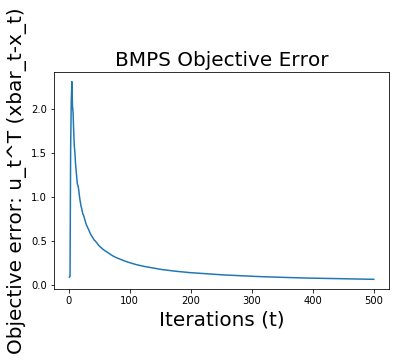

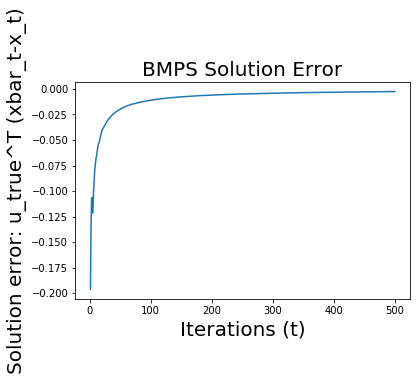

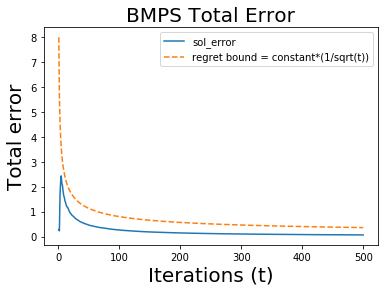

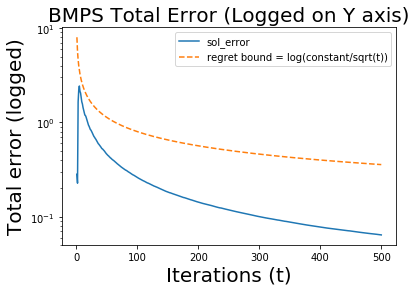

<Figure size 432x288 with 0 Axes>

In [11]:
##### Step 4: Graph BMPS 2018 Error Measures #####
true_u_vec = np.reshape(true_u_vec,(50,1))

BMPS_obj_error = np.zeros((num_samples,))
BMPS_sol_error = np.zeros((num_samples,))
BMPS_total_error = np.zeros((num_samples,))

for i in range(1,num_samples+1): #cannot directly compare graph to paper bc we use 1/sqrt(t) - might need to run for more iterations?
    BMPS_obj_error[i-1] = np.dot(np.transpose(c_t_dict_vecs[i]),(x_t_samples[i]-xbar_dict_vecs[i]))
    BMPS_sol_error[i-1] = np.dot(np.transpose(true_u_vec),(x_t_samples[i]-xbar_dict_vecs[i])) #since we made u_vec as like negative ok?
    BMPS_total_error[i-1] = BMPS_obj_error[i-1] - BMPS_sol_error[i-1] 
 
BMPS_obj_error = np.divide(np.cumsum(BMPS_obj_error),np.arange(1,num_samples+1))
BMPS_sol_error = np.divide(np.cumsum(BMPS_sol_error),np.arange(1,num_samples+1))
BMPS_total_error = np.divide(np.cumsum(BMPS_total_error),np.arange(1,num_samples+1))
    
#################################    
#plt.subplot(131)
error_graph1 = plt.plot(np.arange(1,num_samples+1),BMPS_obj_error)
plt.xlabel('Iterations (t)',fontsize=20)
plt.ylabel('Objective error: u_t^T (xbar_t-x_t)',fontsize=20)
plt.title('BMPS Objective Error',fontsize=20)
plt.figure()

#plt.subplot(132)
error_graph2 = plt.plot(np.arange(1,num_samples+1),BMPS_sol_error)
plt.xlabel('Iterations (t)',fontsize=20)
plt.ylabel('Solution error: u_true^T (xbar_t-x_t)',fontsize=20)
plt.title('BMPS Solution Error',fontsize=20)
plt.figure()

#plt.subplot(133)
constant = 8
bound_func = lambda x: constant*(1/(np.sqrt(x))) #following the lead of BMPS 2018

error_graph3 = plt.plot(np.arange(1,num_samples+1),BMPS_total_error,label="sol_error")
error_graph3 = plt.plot(np.arange(1,num_samples+1),bound_func(np.arange(1,num_samples+1)),'--',\
                        label="regret bound = constant*(1/sqrt(t))")
#error_graph3 = plt.plot(np.arange(1,num_samples+1),BMPS_sol_error)
plt.legend()
plt.xlabel('Iterations (t)',fontsize=20)
plt.ylabel('Total error',fontsize=20)
plt.title('BMPS Total Error',fontsize=20)
plt.figure()

##Plot Logged##
error_graph3 = plt.semilogy(np.arange(1,num_samples+1),BMPS_total_error,label="sol_error")
error_graph3 = plt.semilogy(np.arange(1,num_samples+1),bound_func(np.arange(1,num_samples+1)),'--',\
                            label="regret bound = log(constant/sqrt(t))")
#error_graph3 = plt.plot(np.arange(1,num_samples+1),BMPS_sol_error)
plt.legend()
plt.xlabel('Iterations (t)',fontsize=20)
plt.ylabel('Total error (logged)',fontsize=20)
plt.title('BMPS Total Error (Logged on Y axis)',fontsize=20)
plt.figure()






### Selected References (see documentation for more)

[1] Bärmann, Andreas, Alexander Martin, Sebastian Pokutta, and Oskar Schneider. "An Online-Learning Approach to Inverse Optimization." arXiv preprint arXiv:1810.12997 (2018).